In [1]:
import argparse
from glob import glob
from os import makedirs, path
import pandas as pd
import pickle
import sys
import numpy as np
import nibabel as nib
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from utils.firstlevel_utils import (get_first_level_objs, 
                                    get_first_level_maps, 
                                    load_first_level_objs, 
                                    FirstLevel)
from utils.secondlevel_utils import create_group_mask
from utils.utils import get_contrasts, get_flags


from nipype.interfaces import fsl
from nilearn import image
from nipype.caching import Memory
from nipype.interfaces import fsl

/tmp/ipykernel_684/1916453590.py:11: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.second_level_model import SecondLevelModel
/home/users/sjshim/miniconda3/envs/fmri_analysis/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


211111-16:24:54,104 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 2ndlevel_analysis.ipynb

In [2]:
parser = argparse.ArgumentParser(description='2nd level Entrypoint Script.')
parser.add_argument('-data_dir', default='/data')
parser.add_argument('-derivatives_dir', default=None)
parser.add_argument('--tasks', nargs="+", help="")
parser.add_argument('--rerun', action='store_true')
parser.add_argument('--rt', action='store_true')
parser.add_argument('--beta', action='store_true')
parser.add_argument('--subject_ids', nargs="+")
parser.add_argument('--n_perms', default=1000, type=int)
parser.add_argument('--mask_thresh', default=.95, type=float)
parser.add_argument('--smoothing_fwhm', default=6)
parser.add_argument('--quiet', '-q', action='store_true')
parser.add_argument('--aim', default='NONE', help='Choose from aim1, aim2')
parser.add_argument('--group', default='NONE')

if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.derivatives_dir = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/'
    args.tasks = ['stroop']
    args.rt=True
    args.n_perms = 10

In [3]:
if not args.quiet:
    def verboseprint(*args, **kwargs):
        print(*args, **kwargs)
else:
    def verboseprint(*args, **kwards):  # do-nothing function
        pass

### Setup

Organize paths and set parameters based on arguments

In [4]:
# set paths
data_dir = args.data_dir
data_dir = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS'
first_level_dir = path.join(args.derivatives_dir, '1stlevel')
second_level_dir = path.join(args.derivatives_dir, '2ndlevel')
fmriprep_dir = path.join(args.derivatives_dir, 'SOBC_analysis')

# set tasks
if args.tasks is not None:
    tasks = args.tasks
else:
    tasks = ['cuedTS', 'directedForgetting', 'flanker', 'goNogo',
             'nBack', 'shapeMatching', 'spatialTS', 'stopSignal',
             'stopSignalWDirectedForgetting','stopSignalWFlanker', 'directedForgettingWFlanker']

if not args.subject_ids:
    subjects = sorted([i.split("-")[-1] for i in glob(path.join(data_dir, '*')) if 'sub-' in i])
else:
    subjects = args.subject_ids
#remove pilot subject
subjects.remove('n01')

# set other variables
regress_rt = args.rt
beta_series = args.beta
n_perms = args.n_perms
group = args.group
print(subjects)

['s03', 's10', 's19', 's29', 's43']


### Create Mask

In [5]:
for sub in subjects:
    mask_loc = path.join(second_level_dir, sub,
                         'group_mask_thresh-%s.nii.gz' % str(args.mask_thresh))
    print(mask_loc)
    if (not path.exists(mask_loc)) or args.rerun:
        verboseprint('Making group mask at %s' % mask_loc)
        group_mask = create_group_mask(fmriprep_dir, sub, args.mask_thresh)
        #makedirs(path.dirname(mask_loc), exist_ok=True)
        #group_mask.to_filename(mask_loc)
        print(mask_loc)

/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/2ndlevel/s03/group_mask_thresh-0.95.nii.gz
Making group mask at /oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/2ndlevel/s03/group_mask_thresh-0.95.nii.gz
Creating Group mask...
/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/SOBC_analysis/sub-s03/*/func/*MNI152NLin2009cAsym*brain_mask.nii.gz
59 maps found at /oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/SOBC_analysis
threshold info:
0.95
<class 'float'>
Thresholding, finishing creating group mask
/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/2ndlevel/s03/group_mask_thresh-0.95.nii.gz
/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/2ndlevel/s10/group_mask_thresh-0.95.nii.gz
Making group mask at /oak/stanford/groups/russpold/data/network_grant/discovery_BIDS/derivatives/2ndlevel/s10/group_mask_thresh-0.95.nii.gz
Creating

### Create second level objects
Gather first level models and create second level model

In [61]:
network_2ndlevel_confounds_path = "../aim1_2ndlevel_regressors/" +\
                               "aim1_2ndlevel_confounds_matrix.csv"
full_confounds_df = pd.read_csv(aim1_2ndlevel_confounds_path,
                                index_col='index')

In [62]:
full_confounds_df

,age,sex,ANT_meanFD,CCTHot_meanFD,DPX_meanFD,WATT3_meanFD,discountFix_meanFD,motorSelectiveStop_meanFD,rest_meanFD,stopSignal_meanFD,stroop_meanFD,surveyMedley_meanFD,twoByTwo_meanFD
index,,,,,,,,,,,,,
s061,41.0,1.0,NaN,0.137224,0.108978,0.151611,0.134908,NaN,0.119460,0.125783,0.104488,0.138526,0.124104
s130,27.0,0.0,0.041484,0.031070,0.044276,0.045655,0.036948,0.036940,0.039885,0.031040,0.038328,0.030956,0.038415
s144,19.0,0.0,0.066086,0.074673,NaN,0.077678,NaN,NaN,0.057375,0.056909,NaN,NaN,0.062426
s172,19.0,0.0,0.050340,0.055910,0.068629,0.061671,0.065435,0.067503,0.050112,0.056833,0.063870,0.068802,0.054902
s192,18.0,0.0,0.094071,0.097725,0.066249,0.092005,0.069987,0.072108,0.086492,0.088668,0.067839,0.070347,0.100996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
s646,22.0,1.0,0.061674,0.068604,NaN,0.065120,NaN,NaN,0.060531,0.070464,NaN,NaN,0.074248
s647,24.0,0.0,0.100468,0.090287,0.068654,0.081480,NaN,0.068188,0.061891,0.087776,0.060760,0.074409,0.090747
s648,30.0,0.0,0.061739,0.063606,0.063945,0.063606,0.074744,0.060855,0.059342,0.054841,0.053409,0.044231,0.061739


In [63]:
def fit_and_compute_contrast(maps, task, second_level_model):
    design_matrix, curr_contrasts = get_group_DM_and_contrasts(maps,
                                                               task)
    maps, design_matrix = filter_maps_and_DM(maps, design_matrix)
    second_level_model.fit(maps,
                           design_matrix=design_matrix)
    contrast_map = second_level_model.compute_contrast(
        second_level_contrast=curr_contrasts)
    return contrast_map, maps


def get_group_DM_and_contrasts(maps, task):
    design_matrix = pd.DataFrame([1] * len(maps), columns=['intercept'])
    if args.aim == 'aim1':
        subjects = [m.split('1stlevel/')[-1].split('/')[0] for m in maps]
        design_matrix = full_confounds_df.loc[subjects,
                                              ['age', 'sex', task+'_meanFD']
                                              ].copy()
        design_matrix.index.rename('subject_label', inplace=True)
        design_matrix['intercept'] = 1
    if args.aim == 'aim1_noFD':
        subjects = [m.split('1stlevel/')[-1].split('/')[0] for m in maps]
        design_matrix = full_confounds_df.loc[subjects, ['age', 'sex']].copy()
        design_matrix.index.rename('subject_label', inplace=True)
        design_matrix['intercept'] = 1
    ncols = design_matrix.shape[1]
    contrasts = np.zeros(ncols)
    contrasts[-1] = 1
    contrasts = [int(i) for i in contrasts]
    print(contrasts)
    print(design_matrix.head())
    return design_matrix, contrasts


def filter_maps_and_DM(maps, design_matrix):
    drop_num = design_matrix.isna().any(axis=1).sum()
    print('dropping ' +
          str(drop_num) +
          ' due to missing values in design matrix')
    design_matrix = design_matrix.dropna()
    if len(design_matrix) != len(maps):
        keep_subs = design_matrix.index.tolist()
        maps = [m for m in maps if
                m.split('1stlevel/')[-1].split('/')[0] in keep_subs]
    assert(len(design_matrix) == len(maps))
    return maps, design_matrix

In [64]:
with open('ftests.txt', 'w') as f:
    f.write('1')

In [71]:
def randomise(maps, output_loc, mask_loc, n_perms=500, fwhm=6, group='NONE'):
    contrast_name = maps[0][maps[0].index('contrast')+9:].rstrip('.nii.gz')
    # create 4d image
    concat_images = image.concat_imgs(maps)
    # smooth_concat_images
    concat_images = image.smooth_img(concat_images, fwhm)
    # save concat images temporarily
    concat_loc = path.join(output_loc, 'tmp_concat.nii.gz')
    concat_images.to_filename(concat_loc)
    # run randomise
    mem = Memory(base_dir=output_loc)
    fsl_randomise = mem.cache(fsl.Randomise)
    randomise_results = fsl_randomise(
        in_file=concat_loc,
        demean=False,
        mask=mask_loc,
        one_sample_group_mean=True,
        tfce=False,
        c_thresh=3.1,
        vox_p_values=True,
        var_smooth=10,
        fcon='design.fts',
        f_c_thresh=9.61,
        num_perm=n_perms)
    # save results
    if group == 'NONE':
        tfile_loc = path.join(output_loc,
                              "contrast-%s_raw_tfile.nii.gz" % contrast_name)
        tfile_corrected_loc = path.join(
            output_loc,
            "contrast-%s_corrected_tfile.nii.gz" % contrast_name
            )
    else:
        tfile_loc = path.join(
            output_loc,
            "contrast-%s-%s_raw_tfile.nii.gz" % (contrast_name, group))
        tfile_corrected_loc = path.join(
            output_loc,
            "contrast-%s-%s_corrected_tfile.nii.gz" % (contrast_name, group))
    raw_tfile = randomise_results.outputs.tstat_files[0]
    corrected_tfile = randomise_results.outputs.t_corrected_p_files[0]
    return randomise_results

In [72]:
rt_flag, beta_flag = get_flags(regress_rt, beta_series)
for task in tasks:
    verboseprint('Running 2nd level for %s' % task)

    verboseprint('*** Creating maps')
    task_contrasts = get_contrasts(task, regress_rt)
    maps_dir = path.join(second_level_dir,
                         task,
                         'secondlevel-%s_%s_maps' % (rt_flag, beta_flag))
    makedirs(maps_dir, exist_ok=True)

    # run through each contrast for all participants
    if group == 'NONE':
        for name, contrast in [task_contrasts[0]]:
            second_level_model = SecondLevelModel(
                mask=mask_loc,
                smoothing_fwhm=args.smoothing_fwhm
                )
            maps = get_first_level_maps('*', task,
                                        first_level_dir,
                                        name,
                                        regress_rt,
                                        beta_series)
            
            maps = maps[:25]
            N = str(len(maps)).zfill(2)
            verboseprint('****** %s, %s files found' % (name, N))
            if len(maps) <= 1:
                verboseprint('****** No Maps')
                continue

            contrast_map, maps = fit_and_compute_contrast(maps,
                                                          task,
                                                          second_level_model)
            # save
            contrast_file = path.join(maps_dir, 'contrast-%s.nii.gz' % name)
            
            rand_res = randomise(maps, maps_dir, mask_loc, n_perms=n_perms)
            
#             contrast_map.to_filename(contrast_file)
#             # write metadata
#             with open(path.join(maps_dir, 'metadata.txt'), 'a') as f:
#                 f.write('Contrast-%s: %s maps\n' % (contrast, N))
#             # save corrected map
#             if n_perms > 0:
#                 verboseprint('*** Running Randomise')
                
#                 # write metadata
#                 with open(path.join(maps_dir, 'metadata.txt'), 'a') as f:
#                     f.write(
#                         'Contrast-%s: Randomise run with %s permutations\n' %
#                         (contrast, str(n_perms)))

Running 2nd level for stroop
*** Creating maps


/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.


****** congruency, 25 files found
[1]
   intercept
0          1
1          1
2          1
3          1
4          1
dropping 0 due to missing values in design matrix
201029-11:59:10,694 nipype.workflow INFO:
	 [Node] Setting-up "d8cc802d7ee0cf1e0d14ea223f48b462" in "/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Randomise/d8cc802d7ee0cf1e0d14ea223f48b462".
201029-11:59:11,947 nipype.workflow INFO:
	 [Node] Running "d8cc802d7ee0cf1e0d14ea223f48b462" ("nipype.interfaces.fsl.model.Randomise"), a CommandLine Interface with command:
randomise -i /Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/tmp_concat.nii.gz -o "randomise" -c 3.1 -F 9.61 -f /Users/henrymj/Documents/uh2/Self_Regulation_Ontology_fMRI/fmri_analysis/scripts/notebooks/design.fts -m /Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_

In [73]:
rand_res.outputs


f_corrected_p_files = ['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Randomise/d8cc802d7ee0cf1e0d14ea223f48b462/randomise_vox_corrp_fstat1.nii.gz']
f_p_files = []
fstat_files = ['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Randomise/d8cc802d7ee0cf1e0d14ea223f48b462/randomise_fstat1.nii.gz']
t_corrected_p_files = ['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Randomise/d8cc802d7ee0cf1e0d14ea223f48b462/randomise_vox_corrp_tstat1.nii.gz']
t_p_files = []
tstat_files = ['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Random

In [41]:
import nibabel as nib

In [42]:
def transform_p_val_map(map_path):
    img = nib.load(map_path)
    p_vals = img.get_fdata()
    p_vals[p_vals==0.0] = np.nan
    p_vals = 1 - p_vals
    neg_log_pvals = -np.log10(p_vals)
    return nib.Nifti1Image(neg_log_pvals, img.affine, img.header)

In [43]:
rand_res.outputs.f_corrected_p_files[0]

'/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/nipype_mem/nipype-interfaces-fsl-model-Randomise/2fee147c691ac2d9c7a451800b633847/randomise_vox_corrp_fstat1.nii.gz'

In [46]:
import numpy as np
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
from utils.plot_utils import (plot_design, plot_design_timeseries,
                                         plot_design_heatmap, plot_contrast,
                                         plot_map, plot_task_maps,
                                         get_contrast_title)

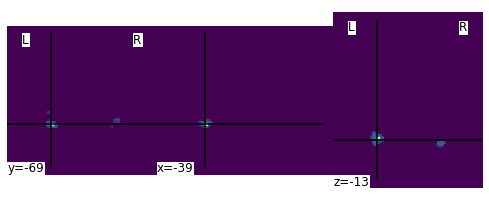

In [45]:
plotting.plot_img(transform_p_val_map(rand_res.outputs.t_corrected_p_files[0]))
plt.show()
plt.close()

f_corrected_p : 1 contrasts
task


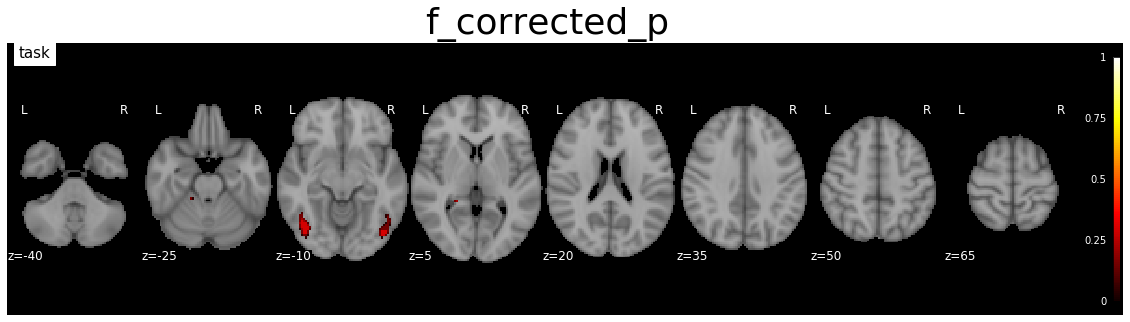

In [53]:
f_transformed_p = plot_task_maps([transform_p_val_map(rand_res.outputs.t_corrected_p_files[0])], 'f_corrected_p', threshold=0, contrast_titles=['task'])

In [ ]:
"""
# Using nistats method of first level objects. Not conducive for randomise.
rt_flag, beta_flag = get_flags(regress_rt, beta_series)
for task in tasks:
    verboseprint('Running 2nd level for %s' % task)
    # load first level models
    first_levels = load_first_level_objs(task, first_level_dir, regress_rt=regress_rt)
    if len(first_levels) == 0:
        continue
    first_level_models = [subj.fit_model for subj in first_levels]
    N = str(len(first_level_models)).zfill(2)

    # simple design for one sample test
    design_matrix = pd.DataFrame([1] * len(first_level_models), columns=['intercept'])
    
    # run second level
    verboseprint('*** Running model. %s first level files found' % N)
    second_level_model = SecondLevelModel(mask=mask_loc, smoothing_fwhm=6).fit(
        first_level_models, design_matrix=design_matrix)
    makedirs(path.join(second_level_dir, task), exist_ok=True)
    f = open(path.join(second_level_dir, task, 'secondlevel_%s_%s.pkl' % (rt_flag, beta_flag)), 'wb')
    pickle.dump(second_level_model, f)
    f.close()
    
    # create contrast maps
    verboseprint('*** Creating maps')
    task_contrasts = get_contrasts(task, regress_rt)
    maps_dir = path.join(second_level_dir, task, 'secondlevel_%s_%s_N-%s_maps' % (rt_flag, beta_flag, N))
    makedirs(maps_dir, exist_ok=True)
    for name, contrast in task_contrasts:
        verboseprint('****** %s' % name)
        contrast_map = second_level_model.compute_contrast(first_level_contrast=contrast)
        contrast_file = path.join(maps_dir, 'contrast-%s.nii.gz' % name)
        contrast_map.to_filename(contrast_file)
"""